In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from math import log10

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from torch.utils.data import TensorDataset, DataLoader, Dataset

from PIL import Image

import os
import sys

In [2]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU {torch.cuda.get_device_name(0)} is available")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead")

GPU Tesla P100-PCIE-16GB is available


In [3]:
# Normalize all image values to 0-1 range
class Normalize01:
    def __call__(self, img):
        return img.float().div(255)

In [4]:
# Custom Dataset class for loading images
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = os.listdir(root)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.images[idx])
        img = Image.open(img_name).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img
    
    def to_tensor(self, verbose=True):
        tensors = []
        
        for idx in range(self.__len__()):
            tensor = self.__getitem__(idx)
            tensors.append(tensor)
            if verbose:
                msg = f"Completed {idx}/{self.__len__()}"
                sys.stdout.write('\r' + msg)
        
        tensors = torch.stack(tensors)
        
        return tensors

In [5]:
# Load the daacosh_tasets
transforms = T.Compose([
    T.ToTensor(),
#     Normalize01(),
])

root = '/kaggle/input/oct-dae-minfiltered/data/'

train_inputs = CustomDataset(root=os.path.join(root, 'inputs', 'train', 'ABNORMAL'), transform=transforms).to_tensor()
test_inputs = CustomDataset(root=os.path.join(root, 'inputs', 'test', 'ABNORMAL'), transform=transforms).to_tensor()
train_targets = CustomDataset(root=os.path.join(root, 'targets', 'train', "ABNORMAL"), transform=transforms).to_tensor()
test_targets = CustomDataset(root=os.path.join(root, 'targets', 'test', "ABNORMAL"), transform=transforms).to_tensor()

Completed 248/24900

In [6]:
print(train_inputs.size())
print(test_inputs.size())
print(train_targets.size())
print(test_targets.size())

torch.Size([6000, 3, 224, 224])
torch.Size([249, 3, 224, 224])
torch.Size([6000, 3, 224, 224])
torch.Size([249, 3, 224, 224])


In [7]:
input_image = train_inputs[5]
target_image = train_targets[5]

In [8]:
print(input_image.shape, target_image.shape)

torch.Size([3, 224, 224]) torch.Size([3, 224, 224])


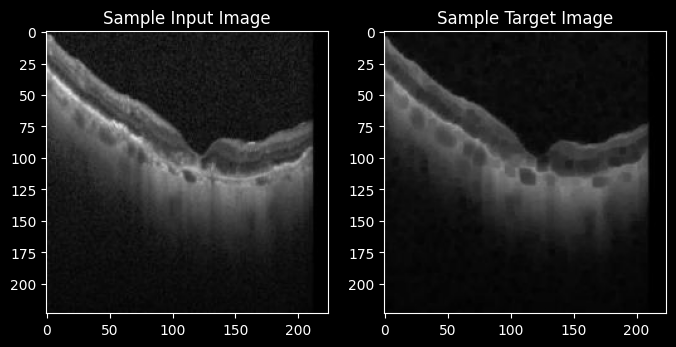

In [9]:
input_image_rgb = np.transpose(input_image, (1, 2, 0))
target_image_rgb = np.transpose(target_image, (1, 2, 0))


fig, ax = plt.subplots(1, 2, figsize = (8, 6))
ax[0].imshow(input_image_rgb)
ax[0].set_title("Sample Input Image")
ax[1].imshow(target_image_rgb)
ax[1].set_title("Sample Target Image")
plt.show()

In [10]:
# Convert to Tensor Datasets
train_data = TensorDataset(train_inputs, train_targets)
test_data = TensorDataset(test_inputs, test_targets)

In [11]:
train_data[1]

(tensor([[[0.0667, 0.1098, 0.1020,  ..., 0.0863, 0.0588, 0.1451],
          [0.0510, 0.0980, 0.0980,  ..., 0.0824, 0.0588, 0.1137],
          [0.0275, 0.0863, 0.0941,  ..., 0.0824, 0.0588, 0.0745],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0196, 0.0196, 0.0157],
          [0.0078, 0.0078, 0.0118,  ..., 0.0157, 0.0157, 0.0118],
          [0.0039, 0.0078, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],
 
         [[0.0667, 0.1098, 0.1020,  ..., 0.0863, 0.0588, 0.1451],
          [0.0510, 0.0980, 0.0980,  ..., 0.0824, 0.0588, 0.1137],
          [0.0275, 0.0863, 0.0941,  ..., 0.0824, 0.0588, 0.0745],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0196, 0.0196, 0.0157],
          [0.0078, 0.0078, 0.0118,  ..., 0.0157, 0.0157, 0.0118],
          [0.0039, 0.0078, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],
 
         [[0.0667, 0.1098, 0.1020,  ..., 0.0863, 0.0588, 0.1451],
          [0.0510, 0.0980, 0.0980,  ..., 0.0824, 0.0588, 0.1137],
          [0.0275, 0.0863, 0.0941,  ...,

In [12]:
# Translate to dataloaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [16]:
def create_autoencoder():

    class ConvolutionalAutoencoder(nn.Module):
        def __init__(self):
            super().__init__()

            """
            Encoder block
            --------------
            Input padding -> Convolution -> Max Pooling.

            """
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
            self.bnorm1 = nn.BatchNorm2d(64)
            # Output size after pooling: np.floor((224+2*1-3)/1)+1 = 224/2 = 112

            self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
            self.bnorm2 = nn.BatchNorm2d(128)
            # Output size after pooling: np.floor((112+2*1-3)/1)+1 = 114/2 = 56

            self.conv3 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=1, padding=1)
            self.bnorm3 = nn.BatchNorm2d(512)
            # Output size after pooling: np.floor((56+2*1-3)/1)+1 = 56/2 = 28
            
            self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
            self.bnorm4 = nn.BatchNorm2d(1024)
            # Output size after pooling: np.floor((28+2*1-3)/1)+1 = 28/2 = 14
        

            """
            Decoder block
            --------------
            """
            self.t_conv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1)
            self.t_bnorm1 = nn.BatchNorm2d(512)
            # Input image size: 14
            # Size after MaxUnpooling: 14*2 = 28
            # Size after transpose convolution and output padding: (28-1)*1 - 2*1 + 1*(3-1) + 0 + 1 = 28

            self.t_conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=3, stride=1, padding=1)
            self.t_bnorm2 = nn.BatchNorm2d(128)
            # Input image size: 28
            # Size after MaxUnpooling: 28*2 = 56
            # Size after transpose convolution and output padding: (56-1)*1 - 2*1 + 1*(3-1) + 0 + 1 = 56

            self.t_conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
            self.t_bnorm3 = nn.BatchNorm2d(64)
            # Input image size: 56
            # Size after MaxUnpooling: 56*2 = 112
            # Size after transpose convolution and output padding: (112-1)*1 - 2*1 + 1*(3-1) + 0 + 1 = 112
            
            self.t_conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1)
            self.t_bnorm4 = nn.BatchNorm2d(3)
            # Input image size: 112
            # Size after MaxUnpooling: 112*2 = 224
            # Size after transpose convolution and output padding: (224-1)*1 - 2*1 + 1*(3-1) + 0 + 1 = 224
            

        def __call__(self, X):
            X, i1, i2, i3, i4 = self.encoder(X)
            yHat = self.decoder(X, i4, i3, i2, i1)
            return yHat

        def encoder(self, X):
            """
            Encoder Block
            -------------
            Convolution -> Max Pooling -> Batch Normalization -> Leaky Relu -> Dropout Regularization

            """
            # 1st layer
            X = self.conv1(X)
            X, indices_conv1 = F.max_pool2d(X, kernel_size=2, return_indices=True)
            X = self.bnorm1(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            # 2nd layer
            X = self.conv2(X)
            X, indices_conv2 = F.max_pool2d(X, kernel_size=2, return_indices=True)
            X = self.bnorm2(X)
            X = F.relu(X)
            X = F.dropout(X , p=0.25, training=self.training)

            # 3rd layer
            X = self.conv3(X)
            X, indices_conv3 = F.max_pool2d(X, kernel_size=2, return_indices=True)
            X = self.bnorm3(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)
            
            X = self.conv4(X)
            X, indices_conv4 = F.max_pool2d(X, kernel_size=2, return_indices=True)
            X = self.bnorm4(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            return X, indices_conv1, indices_conv2, indices_conv3, indices_conv4

        def decoder(self, X, indices_conv4, indices_conv3, indices_conv2, indices_conv1):
            """
            Decoder Block
            -------------
            Max Unpooling -> Transpose Convolution -> Batch Normalization -> Leaky Relu -> Dropout Regularization

            """
            # 1st layer
            X = F.max_unpool2d(X, indices=indices_conv4, kernel_size=2)
            X = self.t_conv1(X)
            X = self.t_bnorm1(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            # 2nd layer
            X = F.max_unpool2d(X, indices=indices_conv3, kernel_size=2)
            X = self.t_conv2(X)
            X = self.t_bnorm2(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            # 3rd layer
            X = F.max_unpool2d(X, indices=indices_conv2, kernel_size=2)
            X = self.t_conv3(X)
            X = self.t_bnorm3(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)
            
            # 4th layer
            X = F.max_unpool2d(X, indices=indices_conv1, kernel_size=2)
            X = self.t_conv4(X)
            X = self.t_bnorm4(X)
            # X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            return F.sigmoid(X)

    # Create a net
    net = ConvolutionalAutoencoder()

    # Loss function
    lossfun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [15]:
# # Test this model with a bit of data
# net, lossfun, optimizer = create_autoencoder()
# net.to(device)
# X, y = next(iter(train_loader))
# yHat = net(X.to(device))

# print(yHat.shape)
# print(yHat.shape)

In [17]:
# Peak Signal to Noise Ratio
def psnr(target_img, input_img, max_val=1.0):
    mse = F.mse_loss(target_img, input_img)
    psnr_value = 20 * log10(max_val) - 10 * log10(mse.item())
    return psnr_value

In [18]:
def train_autoencoder():

    # Number of epochs
    numepochs=15

    # Create a new model
    net, lossfun, optimizer = create_autoencoder()

    # Send the model to the GPU
    net.to(device)
    lossfun.to(device)

    # Initialize the losses
    train_losses = []
    train_psnr = []
    test_losses = []
    test_psnr = []
    
    net.train()

    for epoch in range(numepochs):

        # Initialize batch losses and batch psnr
        train_batch_losses = []
        train_batch_psnr = []
        
        # Training data
        for count, (X, y) in zip(range(1, len(train_loader)),train_loader):

            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_hat = net(X)

            # Compute loss
            loss = lossfun(y_hat, y)
            
            # Compute PSNR
            psnr_val = psnr(target_img=y.cpu(), input_img=X.cpu())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and PSNR from this batch
            train_batch_losses.append(loss.item())
            train_batch_psnr.append(psnr_val)
            
            
            msg = 'Completed {}/{}'.format(count, len(train_loader))
            sys.stdout.write('\r' + msg)

        # average loss and PSNR across the batches
        train_losses.append(np.mean(train_batch_losses))
        train_psnr.append(np.mean(train_batch_psnr))
        
        
        # Test data
        X, y = next(iter(test_loader))
        with torch.no_grad():
            X = X.to(device)
            y = y.to(device)
            
            # Forward Pass
            y_hat = net(X)
            
            # Compute Loss
            loss = lossfun(y_hat, y)
            
            # Compute PSNR
            psnr_val = psnr(target_img=y.cpu(), input_img=X.cpu())
            
            # Loss and PSNR from this batch
            test_losses.append(loss.item())
            test_psnr.append(psnr_val)
            
        print(f' Epoch {epoch+1}/{numepochs}')

    # Switch to eval mode.
    net.eval()

    return train_losses, train_psnr, test_losses, test_psnr, net

In [19]:
# Instantiate Autoencoder
net, lossfun, optimizer = create_autoencoder()

In [20]:
# Utilize multiple GPUs if available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

In [21]:
# Train the Autoencoder
train_losses, train_psnr, test_losses, test_psnr, net = train_autoencoder()

Completed 92/93 Epoch 1/15
Completed 92/93 Epoch 2/15
Completed 92/93 Epoch 3/15
Completed 92/93 Epoch 4/15
Completed 92/93 Epoch 5/15
Completed 92/93 Epoch 6/15
Completed 92/93 Epoch 7/15
Completed 92/93 Epoch 8/15
Completed 92/93 Epoch 9/15
Completed 92/93 Epoch 10/15
Completed 92/93 Epoch 11/15
Completed 92/93 Epoch 12/15
Completed 92/93 Epoch 13/15
Completed 92/93 Epoch 14/15
Completed 92/93 Epoch 15/15


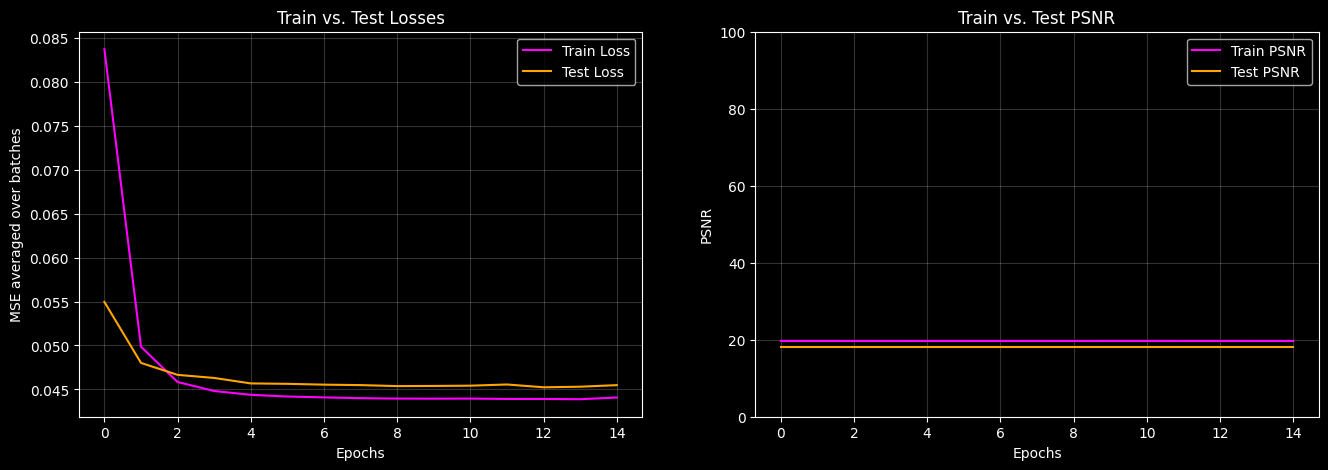

In [22]:
# Visualize the losses

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_losses, label="Train Loss", color='magenta')
ax[0].plot(test_losses, label="Test Loss", color='orange')
ax[0].set_title("Train vs. Test Losses")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("MSE averaged over batches")
ax[0].legend()
ax[0].grid(alpha=0.2)

ax[1].plot(train_psnr, label="Train PSNR", color='magenta')
ax[1].plot(test_psnr, label="Test PSNR", color='orange')
ax[1].set_title("Train vs. Test PSNR")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('PSNR')
ax[1].set_ylim(0, 100)
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.show()

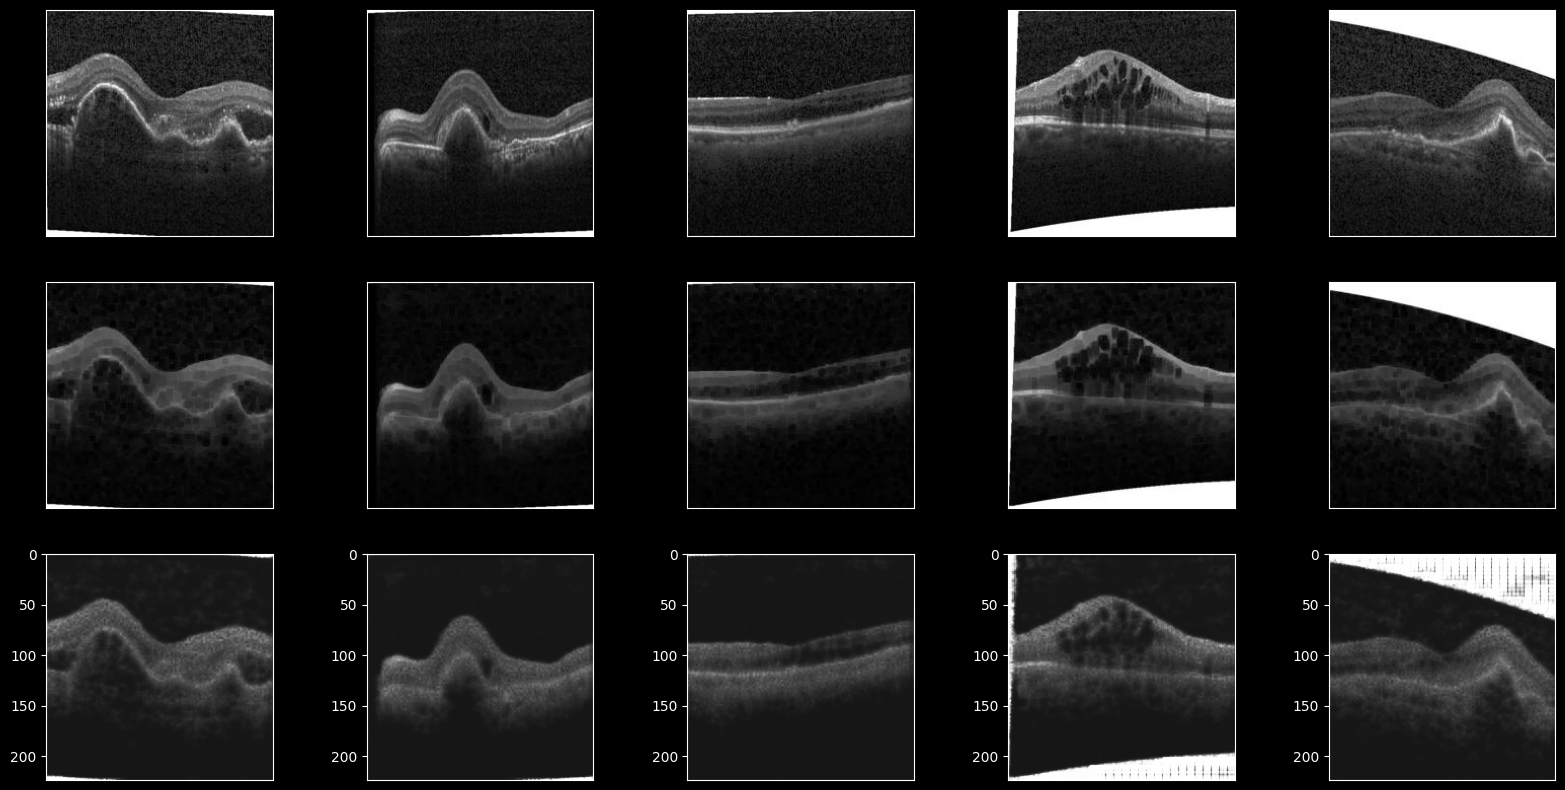

In [23]:
batch = next(iter(test_loader))
X = batch[0][:5].to(device)
y = batch[1][:5]
y_hat = net(X)

# Let's see what the model did!
fig, axs = plt.subplots(3, 5, figsize=(20, 10))

for i in range(5):
    axs[0, i].imshow(X[i].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    axs[1, i].imshow(y[i].permute(1, 2, 0).detach().numpy(), cmap='gray')
    axs[2, i].imshow(y_hat[i].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[1, i].set_yticks([])

plt.show()

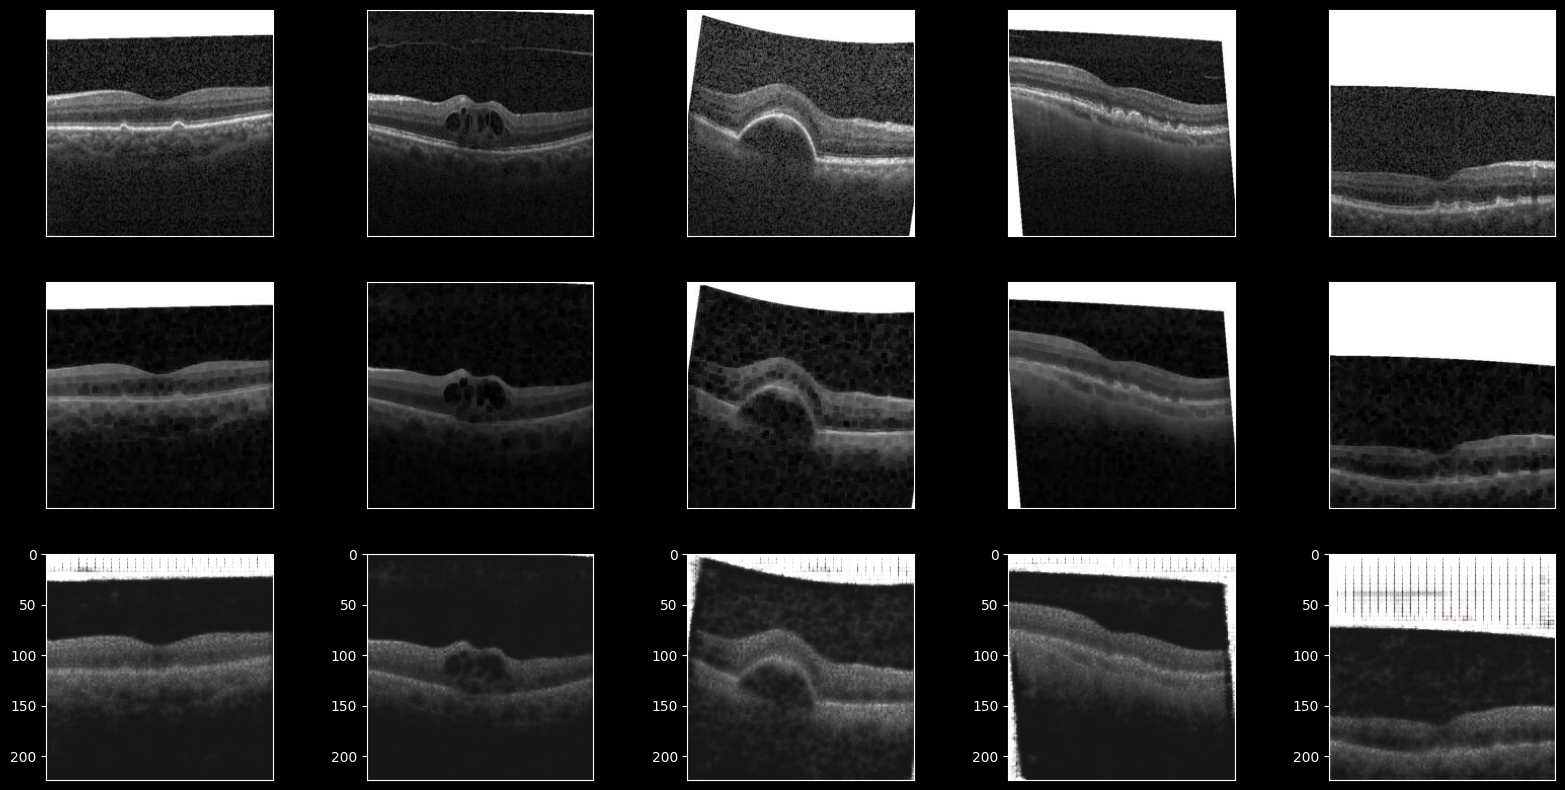

In [24]:
batch = next(iter(test_loader))
X = batch[0][5:11].to(device)
y = batch[1][5:11]
y_hat = net(X)

# Let's see what the model did!
fig, axs = plt.subplots(3, 5, figsize=(20, 10))

for i in range(5):
    axs[0, i].imshow(X[i].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    axs[1, i].imshow(y[i].permute(1, 2, 0).detach().numpy(), cmap='gray')
    axs[2, i].imshow(y_hat[i].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[1, i].set_yticks([])

plt.show()

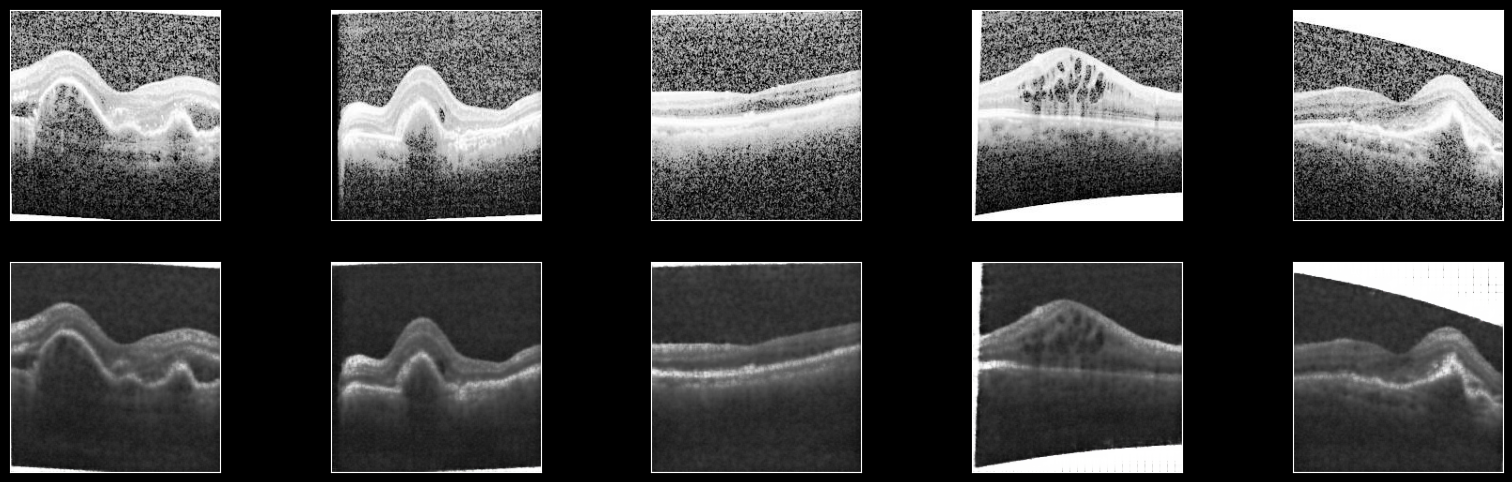

In [18]:
batch = next(iter(test_loader))
X = batch[0][:5].to(device)
y_hat = net(X)

# Let's see what the model did!
fig, axs = plt.subplots(3, 5, figsize=(20, 10))

for i in range(5):
    axs[0, i].imshow(X[i].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    axs[1, i].imshow(y_hat[i].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.show()

In [30]:
torch.save(net.state_dict(), '/kaggle/working/OCT-DAE-V1.pt')